In [1]:
# change directory to ensure imports and downloads work correctly
import os
os.chdir('..')

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy.optimize as spo
import data_processing.primed_utils as primed_utils
from primed_data_processing.arbin_cycler import ArbinBatch

In [68]:
data_array = {}
# for cell_number in (9,10,11,12,1,2,3,4,5,6,7,8):
for cell_number in (9,10,11,12,3,4,13):
    with open(f"aggregate_params/C{cell_number}.npy", "rb") as f:
        data_array[cell_number] = np.load(f, allow_pickle=True)

val_array = {}
for cell_number in (1,2,5,6,7,8,16,14,15):
    with open(f"aggregate_params/C{cell_number}.npy", "rb") as f:
        val_array[cell_number] = np.load(f, allow_pickle=True)

In [81]:
def fix_cell_7_8(val_array):
    for idx, dic in enumerate(val_array[7]):
        dic[25] = dic[23]
    for idx, dic in enumerate(val_array[8]):
        dic[25] = dic[23]
fix_cell_7_8(val_array)

In [36]:
def model(params, efc, mean_c, mean_dod, t, soh_i):
    a = params[0]
    b = params[1]
    c = params[2]
    d = params[3]
    e = params[4]
    alpha = params[5]
    beta = params[6]
    a_mean_c = np.mean(a * mean_c)
    c_mean_dod = np.mean(c * mean_dod)
    return soh_i*np.exp(b * efc * (c_mean_dod ** d + a_mean_c ** e)) - alpha * t ** beta

def get_window_means(data, cycle, idx, i):
    if idx == 0:
        mean_c = np.array([data[1][cycle], data[1][cycle], data[1][cycle], data[1][cycle]])
        mean_dod = np.array([data[2][cycle], data[2][cycle], data[2][cycle], data[2][cycle]])
    elif idx == 1:
        mean_c = np.array([data[1][cycle-i], data[1][cycle], data[1][cycle], data[1][cycle]])
        mean_dod = np.array([data[2][cycle-i], data[2][cycle], data[2][cycle], data[2][cycle]])
    elif idx == 2:
        mean_c = np.array([data[1][cycle-2*i], data[1][cycle-i], data[1][cycle], data[1][cycle]])
        mean_dod = np.array([data[2][cycle-2*i], data[2][cycle-i], data[2][cycle], data[2][cycle]])
    else:
        mean_c = np.array([data[1][cycle-3*i], data[1][cycle-2*i], data[1][cycle-i], data[1][cycle]])
        mean_dod = np.array([data[2][cycle-3*i], data[2][cycle-2*i], data[2][cycle-i], data[2][cycle]])
    return mean_c, mean_dod

def sim_cell(params, data, cell_number, return_soh=False):
    sse = 0
    est_soh = []
    sse_count = 1

    if cell_number in (13,16):
        rng = range(1,max(data[0].keys())+1)
        i = 1

    if cell_number in (9,10,11,12,1,2,3,4,5,6,7,8):
        rng = range(1,max(data[0].keys())+1,2)
        i = 2

    if cell_number == 14:
        rng = range(152,max(data[0].keys())+1)
        i = 1

    if cell_number == 15:
        rng = range(151,max(data[0].keys())+1)
        i = 1

    soh_i = data[4][list(rng)[0]]

    efc = 0
    for idx, cycle in enumerate(rng):
        efc += data[0][cycle]
        time = data[3][cycle]
        mean_c, mean_dod = get_window_means(data, cycle, idx, i)
        est_soh.append(model(params, efc, mean_c, mean_dod, time, soh_i*100))

        if cycle % 2 != 0 and cycle > 1 and cell_number not in (13,16):
            actual_soh = data[4][cycle]
            sse += ((actual_soh*100 - est_soh[-1]) ** 2)/sse_count
            sse_count += 1
        elif cell_number in (13,16) and cycle > 1:
            actual_soh = data[4][cycle]
            sse += ((actual_soh*100 - est_soh[-1]) ** 2)/sse_count
            sse_count += 1
            
    if return_soh:
        return sse, est_soh
    return sse

In [5]:
def obj_func(params, data_array, cell_numbers, cycle_fit=False):

    if cycle_fit:
        params = np.append(params, 1.2974e-2)
        params = np.append(params, 0.7)

    sse = 0
    for cell_number in cell_numbers:
        
        data = data_array[cell_number]

        if cell_number in (13,16):
            sse += sim_cell(params, data, cell_number)

        if cell_number in (9,10,11,12,1,2,3,4,5,6,7,8):
            sse += sim_cell(params, data, cell_number)
            
    return sse

In [652]:
result = spo.least_squares(
    obj_func,
    # [1e-3,1e-3,1e-3,1e-3,7e-4,0.7],
    (3.217e-02, -1.952e-04,  1.137e+00),#,1.3e-4,0.7),
    args = (
        data_array,
        # (9,10,11,12,3,4,13),
        (9,10,11,12,3,4),
        True
    )
)
print(result)

C:\Users\seanb\AppData\Local\Temp\ipykernel_21316\3116902318.py:64: RuntimeWarning: overflow encountered in scalar power
  sse += ((actual_soh*100 - est_soh[-1]) ** 2)/sse_count
C:\Users\seanb\AppData\Local\Temp\ipykernel_21316\3116902318.py:14: RuntimeWarning: overflow encountered in exp
  return soh_i*np.exp(b * efc * (c_mean_dod + a_mean_c * (1-c_mean_dod))) - alpha * t ** beta


     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 7.998e+01]
           x: [ 3.217e-02 -1.641e-04  1.137e+00]
        cost: 3198.38916399801
         jac: [[-6.318e+01 -6.227e+02  3.776e+00]]
        grad: [-5.053e+03 -4.981e+04  3.020e+02]
  optimality: 49806.10641382212
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 22
        njev: 11


In [102]:
global_result = spo.dual_annealing(
    obj_func,
    bounds = (
        (1e-7, 1e-1),
        (-1e-1, -1e-5),
        (1e-3, 1.3),
        (1,3),
        (0,1),
        (1e-3, 1e-1),
        (0.4, 0.8)
    ),
    args=(
        data_array,
        (9,10,11,12,3,4,13),
        # (9,12,4),
        False
    ),
    # maxiter = 10000,
    # initial_temp = 8000,
)

In [103]:
global_result

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 29.27164791190051
       x: [ 9.974e-02 -3.102e-04  6.934e-01  2.995e+00  1.000e+00
            1.000e-01  4.689e-01]
     nit: 1000
    nfev: 15033
    njev: 129
    nhev: 0

In [231]:
# (9,10,11,12,3,4,13)
# (1,2,5,6,7,8,16)
# [ 4.91441030e-04, -2.98808476e-03,  3.09008644e-01,  2.80785041e+00,
#         6.12442315e-01,  1.00000000e-01,  4.61330493e-01]
cell = 15
data = val_array
x = np.append(global_result.x, 1.2974e-2)
x = np.append(x, 0.7)
sse, soh = sim_cell([ 4.91441030e-04, -2.98808476e-03,  3.09008644e-01,  2.80785041e+00,
         6.12442315e-01,  1.00000000e-01,  4.61330493e-01], data[cell], cell, True)

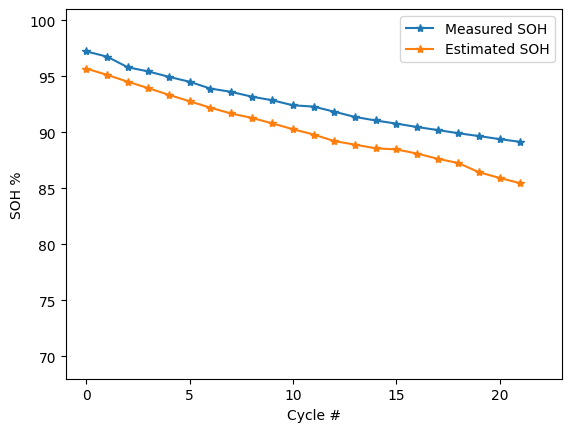

In [232]:
if cell == 14:
    plt.plot([val*100 for idx, val in data[cell][4].items() if idx >=152], marker='*')
elif cell == 15:
    plt.plot([val*100 for idx, val in data[cell][4].items() if idx >=151], marker='*')
else:
    plt.plot(np.array(list(data[cell][4].values()))*100, marker='*')
if cell in (9,10,11,12,1,2,3,4,5,6,7,8):
    plt.plot(soh[:], marker='*')
    pass
else:
    plt.plot(soh, marker='*')
plt.legend(("Measured SOH", "Estimated SOH"))
plt.xlabel("Cycle #")
plt.ylabel("SOH %")
plt.ylim(68, 101)
plt.xlim(-1, 23)
# plt.savefig(os.getcwd() + f"/Images/C{cell}soh_val.png")

In [201]:
os.getcwd()

'c:\\Users\\seanb\\repos\\battery_sizing_model'

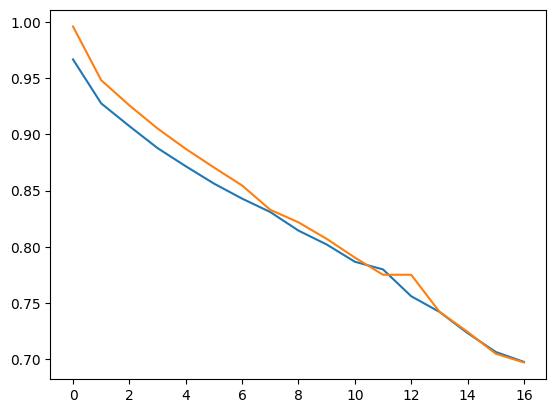

In [178]:
plt.plot(data_array[3][4].values())
plt.plot(val_array[8][4].values())

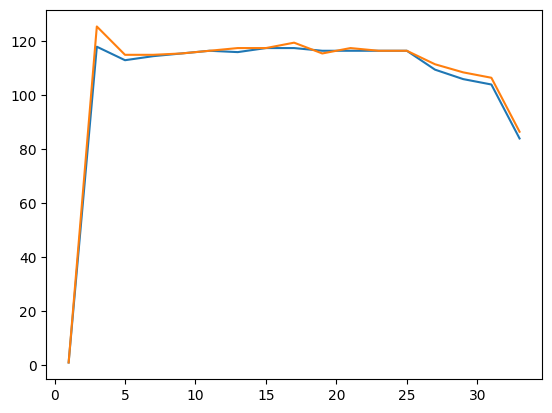

In [189]:
idx = 0
start = 0
plt.plot(list(data_array[3][idx].keys())[start::2], list(data_array[3][idx].values())[start::2])
plt.plot(list(val_array[8][idx].keys())[start::2], list(val_array[8][idx].values())[start::2])

In [23]:
def get_max_error(data, est_soh):
    if cell == 14:
        actual_soh = np.array([val*100 for idx, val in data[4].items() if idx >=152])
    elif cell == 15:
        actual_soh = np.array([val*100 for idx, val in data[4].items() if idx >=151])
    else:
        actual_soh = np.array(list(data[4].values()))*100
    err = np.abs(np.array(est_soh) - actual_soh)
    return np.max(err), np.mean(err)

In [135]:
max_err = {}
mean_err = {}
for cell in val_array.keys():
    sse, soh = sim_cell([ 4.91441030e-04, -2.98808476e-03,  3.09008644e-01,  2.80785041e+00,
        6.12442315e-01,  1.00000000e-01,  4.61330493e-01], val_array[cell], cell, True)
    max_err[cell], mean_err[cell] = get_max_error(val_array[cell], soh)

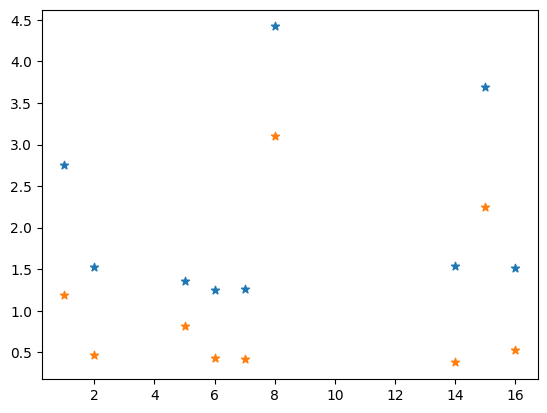

In [136]:
plt.scatter(max_err.keys(), max_err.values(), marker='*')
plt.scatter(mean_err.keys(), mean_err.values(), marker='*')

In [173]:
print(max_err)
print(mean_err)

{1: 2.756761527247704, 2: 1.5309258439360036, 5: 1.357546261668162, 6: 1.2473497359082444, 7: 1.2642659411355766, 8: 4.419994960130651, 16: 1.5182272421844658, 14: 1.53240992414905, 15: 3.6904481121246278}
{1: 1.1911983496021123, 2: 0.4626976883074959, 5: 0.8168340593242746, 6: 0.4356741595550229, 7: 0.41879268920492546, 8: 3.1068491786303203, 16: 0.5270297340000654, 14: 0.37767590709528454, 15: 2.2448932615526456}
